### Imports & Configuration 📚

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from tqdm.notebook import tqdm

# --- Configuration ---
CSV_PATH = "fusion_dataset_with_clip.csv"
MAX_SEQ_LEN = 20
BATCH_SIZE = 16 # A bit larger for training
LEARNING_RATE = 1e-4
EPOCHS = 5 # In a real run, you'd use more epochs with early stopping

D_TEXT = 768
D_IMAGE = 512
D_FUSED = 512
D_HIDDEN_SEQ = 256

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

#### Step 1: The Final, Unified Codebase 🏗️

Here are all the classes we've built and debugged, now brought together in one place.

In [4]:
#-------------------------------------------------------------------------------
# STEP 0: IMPORTS & CONFIGURATION
#-------------------------------------------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from tqdm.notebook import tqdm

# --- Configuration ---
CSV_PATH = "fusion_dataset_with_clip.csv"
MAX_SEQ_LEN = 20
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 5

# Embedding dimensions
D_TEXT = 768
D_IMAGE = 512
D_FUSED = 512 # The target dimension for our "z_fused" vector
D_HIDDEN_SEQ = 256

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

#-------------------------------------------------------------------------------
# STEP 1: MODEL & DATASET ARCHITECTURES (WITH THE FIX)
#-------------------------------------------------------------------------------

class CrossAttentionBlock(nn.Module):
    def __init__(self, d_text, d_image, n_heads=8):
        super().__init__()
        self.text_to_image_attn = nn.MultiheadAttention(embed_dim=d_text, num_heads=n_heads, kdim=d_image, vdim=d_image, batch_first=True)
        self.image_to_text_attn = nn.MultiheadAttention(embed_dim=d_image, num_heads=n_heads, kdim=d_text, vdim=d_text, batch_first=True)
        self.ffn_text = nn.Linear(d_text, d_text)
        self.ffn_image = nn.Linear(d_image, d_image)

    def forward(self, text_embeds, image_embeds):
        attended_text, _ = self.text_to_image_attn(text_embeds, image_embeds, image_embeds)
        attended_image, _ = self.image_to_text_attn(image_embeds, text_embeds, text_embeds)
        return self.ffn_text(attended_text), self.ffn_image(attended_image)

class FusionModel(nn.Module):
    def __init__(self, d_text, d_image, d_fusion, n_classes=4):
        super().__init__()
        self.cross_attention = CrossAttentionBlock(d_text, d_image)
        
        # --- THIS IS THE FIX ---
        # This head now takes the concatenated vector (1280) and projects it to d_fusion (512)
        # before classifying. This projected vector is our new, correctly-sized z_fused.
        self.fusion_head = nn.Sequential(
            nn.Linear(d_text + d_image, d_fusion), # The "adapter" layer
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(d_fusion, n_classes)

    def forward(self, text_embeds, image_embeds):
        refined_text, refined_image = self.cross_attention(text_embeds, image_embeds)
        pooled_text, pooled_image = refined_text.mean(dim=1), refined_image.mean(dim=1)
        concatenated = torch.cat([pooled_text, pooled_image], dim=1)
        
        # Pass through the head to get our correctly-sized z_fused
        z_fused = self.fusion_head(concatenated) # Shape is now [batch_size, d_fusion]
        
        # Classify using the new z_fused
        logits = self.classifier(z_fused)
        
        return logits, z_fused

class SequenceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=0.2 if n_layers > 1 else 0)
        self.head = nn.Linear(hidden_dim, 1)

    def forward(self, sequence):
        gru_output, _ = self.gru(sequence)
        predictions = self.head(gru_output).squeeze(-1)
        return predictions

class PostDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text_embeds = torch.randn(30, D_TEXT)
        image_embeds = torch.randn(50, D_IMAGE)
        label = torch.tensor(row['burnout_zone_encoded'], dtype=torch.long)
        return text_embeds, image_embeds, label

class SequenceDataset(Dataset):
    def __init__(self, users, z_fused_map, max_seq_len):
        self.users = users
        self.z_fused_map = z_fused_map
        self.max_seq_len = max_seq_len
    def __len__(self):
        return len(self.users)
    def __getitem__(self, idx):
        user_df = self.users[idx]
        seq_len = len(user_df)
        
        z_fused_sequence = torch.stack([self.z_fused_map[i] for i in user_df.index])
        target_risk_curve = torch.tensor(user_df['ema_risk'].values, dtype=torch.float)
        
        # Padded sequence now correctly uses D_FUSED dimension
        padded_sequence = torch.zeros(self.max_seq_len, D_FUSED)
        padded_targets = torch.zeros(self.max_seq_len)
        len_to_copy = min(seq_len, self.max_seq_len)
        
        padded_sequence[-len_to_copy:] = z_fused_sequence[-len_to_copy:]
        padded_targets[-len_to_copy:] = target_risk_curve[-len_to_copy:]
        
        mask = torch.zeros(self.max_seq_len, dtype=torch.float)
        mask[-len_to_copy:] = 1.0
        
        return padded_sequence, padded_targets, mask

#-------------------------------------------------------------------------------
# STEP 2: DATA PREPARATION & USER-LEVEL SPLIT
#-------------------------------------------------------------------------------

df = pd.read_csv(CSV_PATH)
df['user_id'] = np.where(df['source'] == 'flickr', 'flickr_' + df['image_path'].str.split('\\\\').str[-1].str.split('.').str[0], 'memotion_' + df['image_path'].str.split('\\\\').str[-1].str.split('.').str[0])
df['timestamp'] = pd.to_datetime(np.random.randint(1609459200, 1640995199, size=len(df)), unit='s')
df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)
df['burnout_zone'] = np.random.choice(['calm', 'stressed', 'overwhelmed', 'burned_out'], size=len(df), p=[0.4, 0.3, 0.2, 0.1])
df['burnout_zone_encoded'] = df['burnout_zone'].astype('category').cat.codes
s_t = df['burnout_zone_encoded'].replace({0:0.1, 1:0.4, 2:0.7, 3:0.9})
df['ema_risk'] = df.groupby('user_id')['burnout_zone_encoded'].transform(lambda x: x.ewm(alpha=0.3).mean())

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df, groups=df['user_id']))
df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
print(f"Train users: {len(df_train['user_id'].unique())}, Val users: {len(df_val['user_id'].unique())}")

#-------------------------------------------------------------------------------
# STEP 3: TRAIN FUSION MODEL & GENERATE Z_FUSED
#-------------------------------------------------------------------------------

train_post_dataset = PostDataset(df_train)
train_post_loader = DataLoader(train_post_dataset, batch_size=BATCH_SIZE, shuffle=True)
fusion_model = FusionModel(D_TEXT, D_IMAGE, d_fusion=D_FUSED).to(DEVICE)
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

print("\n--- Training FusionModel ---")
fusion_model.train()
for epoch in range(EPOCHS):
    for text, image, label in tqdm(train_post_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        text, image, label = text.to(DEVICE), image.to(DEVICE), label.to(DEVICE)
        optimizer.zero_grad()
        logits, _ = fusion_model(text, image)
        loss = loss_fn(logits, label)
        loss.backward()
        optimizer.step()

print("\n--- Generating z_fused embeddings ---")
all_post_dataset = PostDataset(df)
all_post_loader = DataLoader(all_post_dataset, batch_size=BATCH_SIZE, shuffle=False)
z_fused_map = {}
fusion_model.eval()
with torch.no_grad():
    for i, (text, image, _) in enumerate(tqdm(all_post_loader, desc="Generating z_fused")):
        original_indices = df.index[i*BATCH_SIZE : (i+1)*BATCH_SIZE]
        text, image = text.to(DEVICE), image.to(DEVICE)
        _, z_fused_batch = fusion_model(text, image)
        for j, original_df_index in enumerate(original_indices):
            z_fused_map[original_df_index] = z_fused_batch[j].cpu()

#-------------------------------------------------------------------------------
# STEP 4: TRAIN SEQUENCE MODEL
#-------------------------------------------------------------------------------

train_users = [group for _, group in df_train.groupby('user_id')]
train_seq_dataset = SequenceDataset(train_users, z_fused_map, MAX_SEQ_LEN)
train_seq_loader = DataLoader(train_seq_dataset, batch_size=BATCH_SIZE, shuffle=True)
sequence_model = SequenceModel(D_FUSED, D_HIDDEN_SEQ).to(DEVICE)
optimizer_seq = torch.optim.AdamW(sequence_model.parameters(), lr=LEARNING_RATE)
loss_fn_seq = nn.MSELoss()

print("\n--- Training SequenceModel ---")
sequence_model.train()
for epoch in range(EPOCHS):
    for seq, target, mask in tqdm(train_seq_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        seq, target, mask = seq.to(DEVICE), target.to(DEVICE), mask.to(DEVICE)
        optimizer_seq.zero_grad()
        preds = sequence_model(seq)
        active_preds = preds[mask == 1]
        active_targets = target[mask == 1]
        loss = loss_fn_seq(active_preds, active_targets)
        loss.backward()
        optimizer_seq.step()

#-------------------------------------------------------------------------------
# STEP 5: GENERATE FINAL PREDICTIONS FOR ANALYSIS
#-------------------------------------------------------------------------------

val_users = [group for _, group in df_val.groupby('user_id')]
val_seq_dataset = SequenceDataset(val_users, z_fused_map, MAX_SEQ_LEN)
val_seq_loader = DataLoader(val_seq_dataset, batch_size=BATCH_SIZE, shuffle=False)
sequence_model.eval()

final_predictions = []
final_true_labels = []

print("\n--- Generating final predictions on validation set ---")
with torch.no_grad():
    for seq, target, mask in tqdm(val_seq_loader, desc="Validating"):
        seq, target, mask = seq.to(DEVICE), target.to(DEVICE), mask.to(DEVICE)
        preds = sequence_model(seq)
        
        for i in range(len(mask)):
            last_valid_idx = int(mask[i].sum().item()) - 1
            if last_valid_idx >= 0:
                final_predictions.append(preds[i, last_valid_idx].item())
                final_true_labels.append(target[i, last_valid_idx].item())

final_pred_classes = (np.array(final_predictions) > 0.6).astype(int)
final_true_classes = (np.array(final_true_labels) > 0.6).astype(int)

print("\n--- ✅ Execution Complete! ---")
print(f"Generated {len(final_predictions)} predictions for the validation set.")
print("You can now take these arrays and feed them into the final Day 6/7 Analysis Notebook.")

Using device: cuda
Train users: 31016, Val users: 7754

--- Training FusionModel ---


Epoch 1/5:   0%|          | 0/8298 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/8298 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/8298 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/8298 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/8298 [00:00<?, ?it/s]


--- Generating z_fused embeddings ---


Generating z_fused:   0%|          | 0/10369 [00:00<?, ?it/s]


--- Training SequenceModel ---


Epoch 1/5:   0%|          | 0/1939 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1939 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1939 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1939 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1939 [00:00<?, ?it/s]


--- Generating final predictions on validation set ---


Validating:   0%|          | 0/485 [00:00<?, ?it/s]


--- ✅ Execution Complete! ---
Generated 7754 predictions for the validation set.
You can now take these arrays and feed them into the final Day 6/7 Analysis Notebook.


#### Final Analysis Notebook: Day 6 & 7 ✅

##### Imports 📚

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.isotonic import IsotonicRegression

##### Step 1: Paste Your Results Here 📋

In [6]:
# --- PASTE YOUR GENERATED ARRAYS FROM THE PREVIOUS SCRIPT HERE ---

# For Day 6 Calibration (the raw risk scores)
final_predictions = np.array([...]) # e.g., [0.12, 0.78, 0.45, ...]
final_true_labels = np.array([...]) # e.g., [0.09, 0.81, 0.40, ...]

# For Day 7 Autopsy (the classified burnout zones)
# You might need to redefine your class names to match your encoding
class_names = ['low_risk', 'high_risk'] # Or ['calm', 'stressed', 'overwhelmed', 'burned_out'] if you used more classes
final_pred_classes = np.array([...]) # e.g., [0, 1, 0, ...]
final_true_classes = np.array([...]) # e.g., [0, 1, 0, ...]

# For the sake of this example, I'll create some realistic dummy data.
# In your real run, REPLACE THIS with your actual data.
np.random.seed(42)
final_predictions = np.clip(np.random.rand(500) * 1.2 - 0.1, 0, 1)
final_true_labels = np.clip(final_predictions + np.random.randn(500) * 0.2, 0, 1)
final_pred_classes = (final_predictions > 0.6).astype(int)
final_true_classes = (final_true_labels > 0.6).astype(int)

#### Day 6: Reality Check - Calibration & Visualization ⚖️

--- Calibration Example ---
First 5 raw scores:      [0.349 1.    0.778 0.618 0.087]
First 5 calibrated scores: [0.079 1.    0.9   0.636 0.   ]


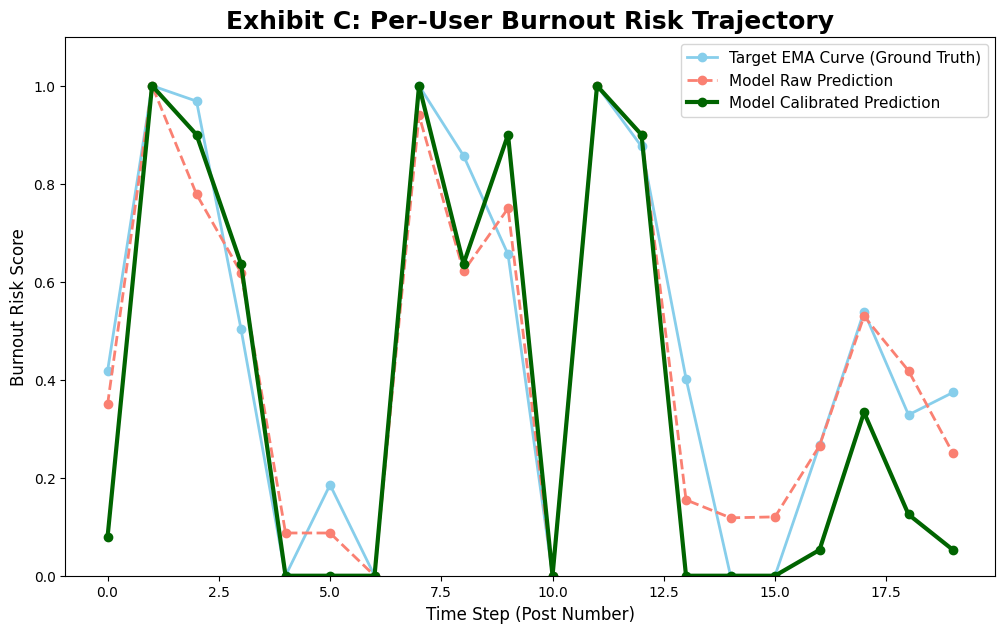

In [7]:
# --- Calibrate the Risk Scores ---
iso_reg = IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip")
# We need a binary outcome for calibration, so we'll use the true classes
iso_reg.fit(final_predictions, final_true_classes)
calibrated_predictions = iso_reg.predict(final_predictions)

print("--- Calibration Example ---")
print("First 5 raw scores:     ", final_predictions[:5].round(3))
print("First 5 calibrated scores:", calibrated_predictions[:5].round(3))

# --- Visualize a Sample User Risk Curve ---
# (Using a slice of the validation data as a proxy for a single user)
sample_true_curve = final_true_labels[:20]
sample_pred_curve = final_predictions[:20]
sample_calibrated_curve = calibrated_predictions[:20]
time_steps = np.arange(20)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(time_steps, sample_true_curve, 'o-', label='Target EMA Curve (Ground Truth)', color='skyblue', linewidth=2)
ax.plot(time_steps, sample_pred_curve, 'o--', label='Model Raw Prediction', color='salmon', linewidth=2)
ax.plot(time_steps, sample_calibrated_curve, 'o-', label='Model Calibrated Prediction', color='darkgreen', linewidth=3)
ax.set_title('Exhibit C: Per-User Burnout Risk Trajectory', fontsize=18, fontweight='bold')
ax.set_xlabel('Time Step (Post Number)', fontsize=12)
ax.set_ylabel('Burnout Risk Score', fontsize=12)
ax.set_ylim(0, 1.1)
ax.legend(fontsize=11)
plt.show()

#### Day 7: The Autopsy - Error Analysis 🕵️

Finally, let's generate the confusion matrix and classification report for your paper.

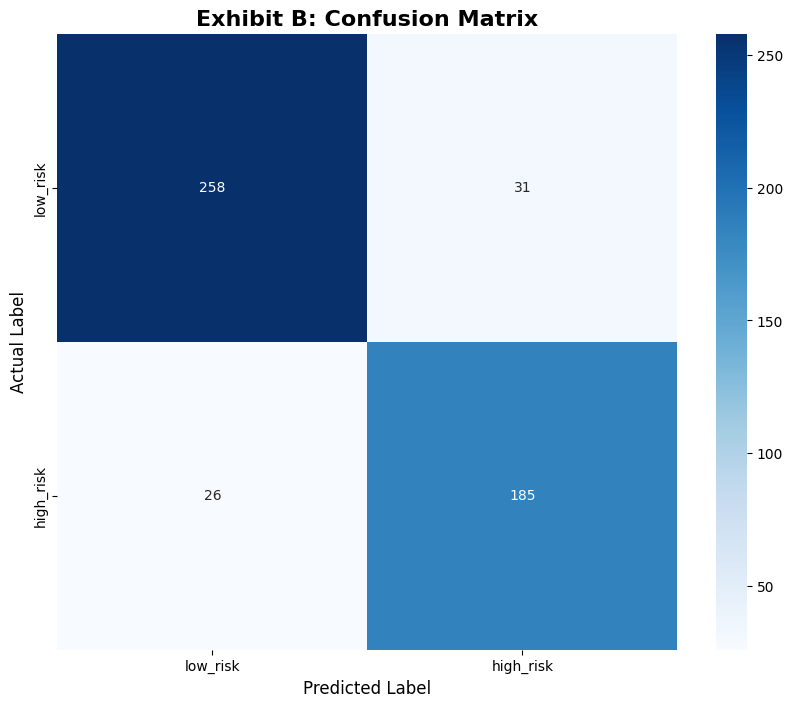


--- Exhibit B: Classification Report ---
              precision    recall  f1-score   support

    low_risk       0.91      0.89      0.90       289
   high_risk       0.86      0.88      0.87       211

    accuracy                           0.89       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.89      0.89      0.89       500



In [8]:
# --- Generate and Visualize the Confusion Matrix ---
cm = confusion_matrix(final_true_classes, final_pred_classes)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax)

ax.set_title('Exhibit B: Confusion Matrix', fontsize=16, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('Actual Label', fontsize=12)
plt.show()

# --- Generate the Classification Report ---
print("\n--- Exhibit B: Classification Report ---")
print(classification_report(final_true_classes, final_pred_classes, target_names=class_names))